In [2]:
paste("R version is:", paste0(R.Version()[c("major","minor")], collapse = "."))

[1] "R version is: 4.0.2"

## Opening the black box

In [2]:
# installing ggplot2 library, if not yet available
if (!("ggplot2" %in% rownames(installed.packages()))) {
    install.packages("ggplot2")
}

In [3]:
# installing clusterSim library, if not yet available
if (!("clusterSim" %in% rownames(installed.packages()))) {
    install.packages("clusterSim")
}

Using clusterSim we can easily create a two half-moons haped dataset.

Loading required package: cluster

Loading required package: MASS



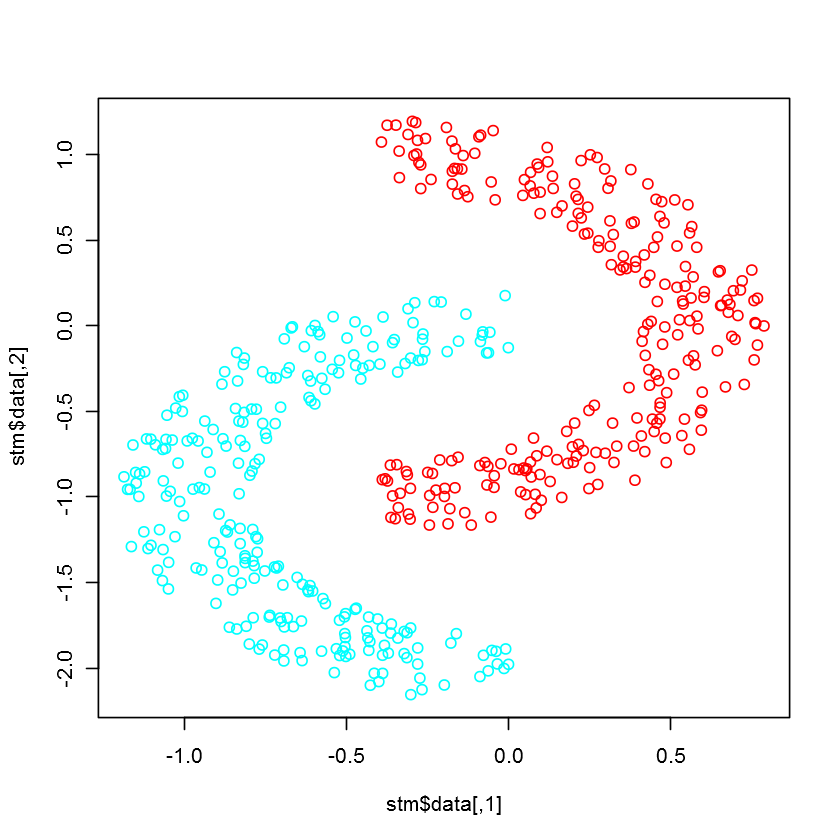

In [4]:
library(clusterSim)
stm <- shapes.two.moon(250)
plot(stm$data, col=rainbow(2)[stm$clusters])

# Splitting the data frame into train and test sets
set.seed(0)
sample_size <- floor(0.7 * nrow(stm$data))
train_idx <- sample(seq_len(nrow(stm$data)), size = sample_size)

X <- stm$data[train_idx,]
y <- as.numeric(stm$clusters[train_idx]==1) 
Xt  <- stm$data[-train_idx,]
yt  <- as.numeric(stm$clusters[-train_idx]==1)

In [5]:
# On Windows, first install Rtools following instructions at: https://cran.r-project.org/bin/windows/Rtools/

if (!("keras" %in% rownames(installed.packages()))) {
    install.packages("backports", type='binary')
    install.packages("devtools")
    devtools::install_github("rstudio/keras", force=TRUE)
    reticulate::py_config()
} else {
    reticulate::py_config()
}

# If necessary, please download and install Rtools 3.5 from http://cran.r-project.org/bin/windows/Rtools/

python:         C:/Users/Luca/anaconda3/python.exe
libpython:      C:/Users/Luca/anaconda3/python37.dll
pythonhome:     C:/Users/Luca/anaconda3
version:        3.7.6 (default, Jan  8 2020, 20:23:39) [MSC v.1916 64 bit (AMD64)]
Architecture:   64bit
numpy:          C:/Users/Luca/anaconda3/Lib/site-packages/numpy
numpy_version:  1.18.1

python versions found: 
 C:/Users/Luca/anaconda3/python.exe
 C:/Users/Luca/anaconda3/envs/algo4dummies/python.exe
 C:/Users/Luca/anaconda3/envs/dl4dummies/python.exe
 C:/Users/Luca/anaconda3/envs/ml4d/python.exe
 C:/Users/Luca/anaconda3/envs/ml4dit/python.exe
 C:/Users/Luca/anaconda3/envs/p4ds4d/python.exe

Thanks to reticulate, the R Keras models are exactly the same as the Python ones. You can refer to the Python documentation for all the details.

In [6]:
library(keras)

# Add layers to the model

model <- keras_model_sequential() %>% 
  layer_dense(units = 8, activation = 'relu', input_shape = c(2)) %>% 
  layer_dense(units = 8, activation = 'relu') %>% 
  layer_dropout(rate=0.2) %>%
  layer_dense(units = 1, activation = 'sigmoid')

# Compile the model
model %>% compile(
  loss = loss_binary_crossentropy,
  optimizer = optimizer_adam(),
  metrics=c('acc')
)

# Summary of the model
model

Model
Model: "sequential"
________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
dense (Dense)                       (None, 8)                       24          
________________________________________________________________________________
dense_1 (Dense)                     (None, 8)                       72          
________________________________________________________________________________
dropout (Dropout)                   (None, 8)                       0           
________________________________________________________________________________
dense_2 (Dense)                     (None, 1)                       9           
Total params: 105
Trainable params: 105
Non-trainable params: 0
________________________________________________________________________________



In [7]:
# Setting the model's training parameters
epochs<-5000
batch_size<-64

# Training the model
history <- model %>% fit(
    X, y,
    batch_size=batch_size,
    epochs=epochs,
    verbose=0,
    shuffle=TRUE
        )

In [8]:
# Evaluate the performances on the test set
scores <- model %>% evaluate(Xt, yt, verbose=0)

# Printing the scores
cat('Test loss:', scores[[1]], '\n')
cat('Test accuracy:', scores[[2]], '\n')

Test loss: 0.01180945 
Test accuracy: 0.9933333 


Plotting the model boundaries is a bit tricky in R: first you create a grid of values for x and y, then you combine the dimensions using expand.grid, finally you predict on the combination.

In [9]:
# Create a sequence of incrementally increasing (by 0.01 units) values
xgrid <-  seq(min(X[,1]), max(X[,1]), 0.01)
ygrid <-  seq(min(X[,2]), max(X[,2]), 0.01)

# Generate a dataframe with every possible combination of x and y
pred.mat <-  expand.grid(x=xgrid, y=ygrid)

# Generate predictions on the grid
preds <- model %>% predict(as.matrix(pred.mat))

The result is plotted using the function contour.

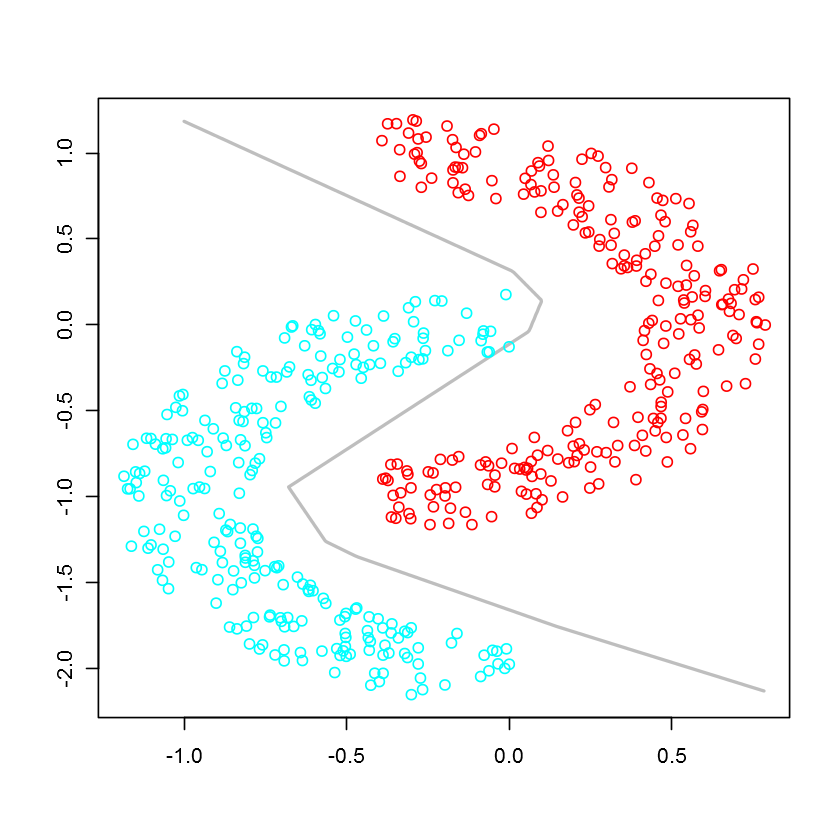

In [10]:
# plot the boundary
contour(x=xgrid, 
        y=ygrid, 
        z=matrix(preds, nrow=length(xgrid), ncol=length(ygrid)), 
        levels=0.5,
        col="grey", 
        drawlabels=FALSE, 
        lwd=2)

# add points from test dataset
points(stm$data, col=rainbow(2)[stm$clusters])

## Explaining the magic of convolutions

In [11]:
library(keras)

# loading the fashion mnist dataset
fashion_mnist <- dataset_fashion_mnist()

# splitting into train and test data
c(x_train, y_train) %<-% fashion_mnist$train
c(x_test, y_test) %<-% fashion_mnist$test

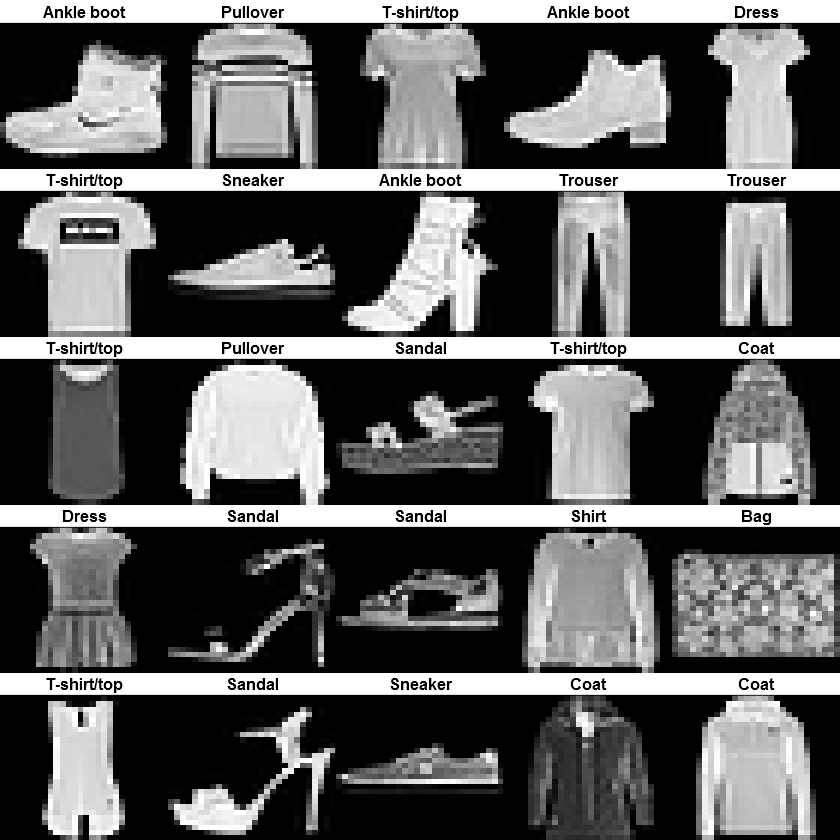

In [12]:
# plotting a few images from the dataset
class_names = c('T-shirt/top',
                'Trouser',
                'Pullover',
                'Dress',
                'Coat', 
                'Sandal',
                'Shirt',
                'Sneaker',
                'Bag',
                'Ankle boot')

library(ggplot2)

par(mfcol=c(5,5))
par(mar=c(0, 0, 1.5, 0), xaxs='i', yaxs='i')
for (i in 1:25) { 
  img <- x_train[i, , ]
  img <- t(apply(img, 2, rev)) 
  image(1:28, 1:28, img, col = gray((0:255)/255), xaxt = 'n', yaxt = 'n',
        main = paste(class_names[y_train[i] + 1]))
}

In [13]:
# setting the number of classes
num_classes <- 10

# normalizing images in the range [0, 1]
x_train <- x_train / 255.
x_test <- x_test / 255.

In [40]:
# Add layers to the model
model <- keras_model_sequential() %>% 
  layer_reshape(target_shape = c(28, 28, 1), 
                input_shape = c(28, 28)) %>%
  layer_conv_2d(filters=32, 
               kernel_size=c(3, 3),
               activation='relu', 
               ) %>% 
  layer_conv_2d(filters=64, 
               kernel_size=c(3, 3),
               activation='relu') %>% 
  layer_max_pooling_2d(pool_size=c(2, 2)) %>%
  layer_flatten() %>%
  layer_dense(units = 32, activation = 'relu') %>% 
  layer_dropout(rate=0.2) %>%
  layer_dense(units = num_classes, activation = 'softmax')

# Compile the model
model %>% compile(
  loss = 'sparse_categorical_crossentropy',
  optimizer = optimizer_adam(),
  metrics=c('accuracy')
)

# Summary of the model
model

Model
Model: "sequential_5"
________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
reshape_4 (Reshape)                 (None, 28, 28, 1)               0           
________________________________________________________________________________
conv2d_8 (Conv2D)                   (None, 26, 26, 32)              320         
________________________________________________________________________________
conv2d_9 (Conv2D)                   (None, 24, 24, 64)              18496       
________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)      (None, 12, 12, 64)              0           
________________________________________________________________________________
flatten_4 (Flatten)                 (None, 9216)                    0           
________________________________________________________________________________


In [41]:
# Setting the model's training parameters
epochs<-11
batch_size<-64

# Training the model
model %>% fit(
    x_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_split=0.2)

In [42]:
# Evaluate the performances on the test set
scores <- model %>% evaluate(x_test, y_test, verbose=0)

# Printing the scores
cat('Test loss:', scores[[1]], '\n')
cat('Test accuracy:', scores[[2]], '\n')

Test loss: 0.3882393 
Test accuracy: 0.8536 


## Understanding recurrent neural networks

In [ ]:
# installing feather library, if not yet available
if (!("feather" %in% rownames(installed.packages()))) {
    install.packages("feather")
}

In [ ]:
# installing RCurl library, if not yet available
if (!("RCurl" %in% rownames(installed.packages()))) {
    install.packages("RCurl")
}

In [4]:
library(feather)
library(RCurl)

In [5]:
url <- "https://github.com/lmassaron/datasets/releases/download/1.0/air_passengers.feather"
destfile <- "imdb_50k.feather"
download.file(url, destfile, mode =  "wb")

passengers <- read_feather(destfile)

Warning message:
"Coercing int64 to double"


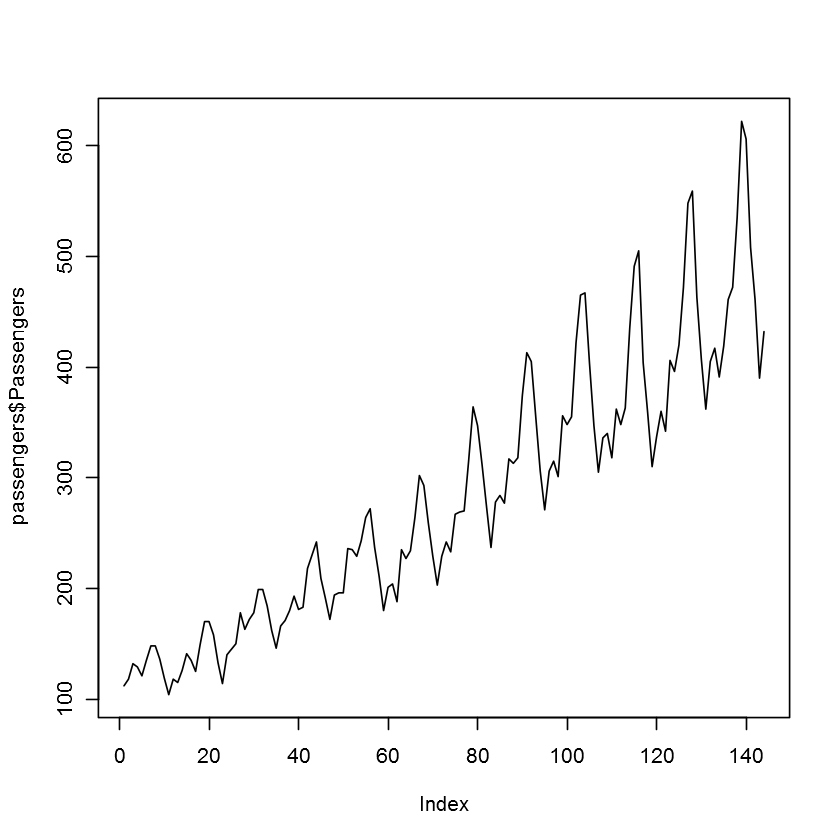

In [183]:
plot(passengers$Passengers, type='l')

We only remind you that, if your data has a monthly seasonality, and your are learning your model through windows of data, you have to set your windows at least to 12 months or the model won't really learn how monthly seasonality works. This happens also for classical times series models.

In [145]:
library(data.table)
lookback <- 12

sequence <- as.data.frame(data.table::shift(passengers$Passengers,0:lookback))
sequence <- sequence[(lookback+1):nrow(sequence),]
colnames(sequence) <- as.character(0:lookback)

In [146]:
y <- as.numeric(sequence[,1])
X <- as.matrix(sequence[,2:ncol(sequence)])

In [147]:
max_value <- max(y)

y_train <- y[1:(length(y)-24)] / max_value
X_train <- X[1:(length(y)-24),] / max_value
 
y_test <- y[(length(y)-24):length(y)] / max_value
X_test <- X[(length(y)-24):length(y),] / max_value

In [185]:
library(keras)

# Add layers to the model
model <- keras_model_sequential() %>%
  layer_reshape(target_shape = c(1, lookback), 
                input_shape = c(lookback)) %>%
  layer_lstm(units = 4) %>%
  layer_dense(units = 4, activation = 'relu', ) %>% 
  layer_dense(units = 1)

# Compile the model
model %>% compile(
  loss = 'mse',
  optimizer = optimizer_adam(),
  metrics=c('mean_absolute_error')
)

# Summary of the model
model

Model
Model: "sequential_13"
________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
reshape_9 (Reshape)                 (None, 1, 12)                   0           
________________________________________________________________________________
lstm_6 (LSTM)                       (None, 4)                       272         
________________________________________________________________________________
dense_18 (Dense)                    (None, 4)                       20          
________________________________________________________________________________
dense_19 (Dense)                    (None, 1)                       5           
Total params: 297
Trainable params: 297
Non-trainable params: 0
________________________________________________________________________________



In [198]:
# Setting the model's training parameters
epochs<-300
batch_size<-8

# Training the model
model %>% fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    shuffle=TRUE,
    verbose=1)

In [199]:
preds <- model %>% predict(X_test, verbose=0) * max_value
true <- y_test * max_value

In [200]:
rmse <- sqrt(mean((preds - true)^2))
cat(paste("RMSE:", round(rmse,1)))

RMSE: 36.6

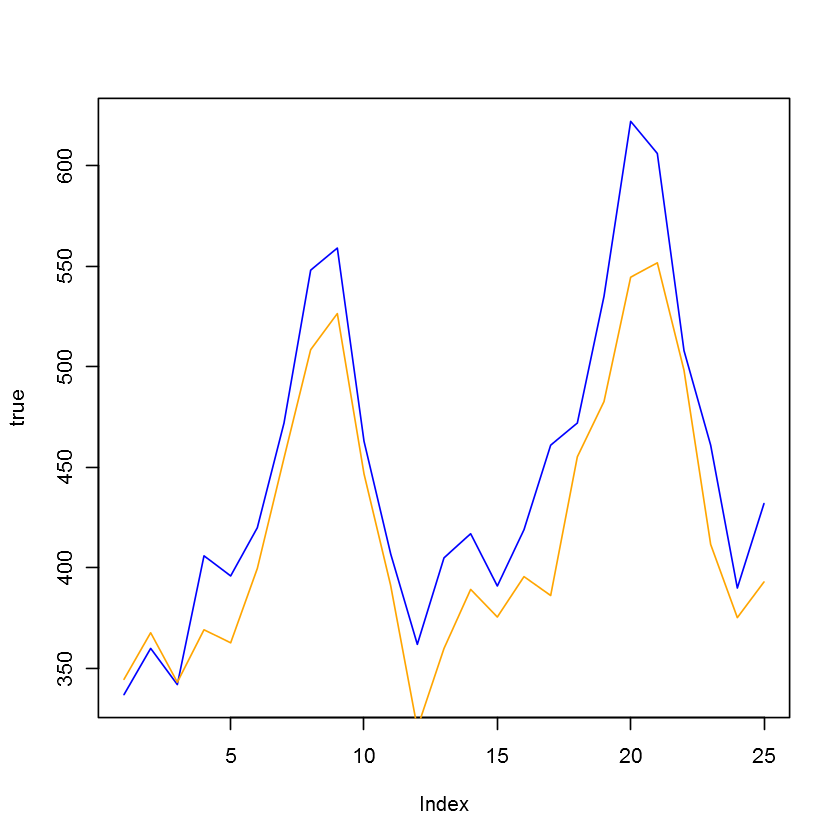

In [201]:
plot(true, type="l", col='blue')
lines(preds, col='orange')